# RAIDIUM MEDICAL ORGANS CLUSTERING PROJECT

## Imports

In [1]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   4
  On-line CPU(s) list:    0-3
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   2
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.34
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

In [2]:
!pip3 install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
!pip -q install iterative-stratification

In [ ]:
import tensorflow as tf  
# Check if GPU is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Ensure TensorFlow uses GPU
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

## Fetching dataset

In [20]:
!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv

--2025-03-07 19:33:53--  https://challengedata.ens.fr/media/public/label_Hnl61pT.csv
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267819968 (255M) [text/csv]
Saving to: ‘y_train.csv’

y_train.csv         100%[===================>] 255.41M  19.5MB/s    in 14s     

2025-03-07 19:34:07 (18.9 MB/s) - ‘y_train.csv’ saved [267819968/267819968]



In [21]:
# downloading the images

!wget https://challengedata.ens.fr/media/public/train-images.zip
!wget  https://challengedata.ens.fr/media/public/test-images.zip
!wget https://challengedata.ens.fr/media/public/annotated_labels.json

--2025-03-07 19:34:07--  https://challengedata.ens.fr/media/public/train-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52391647 (50M) [application/zip]
Saving to: ‘train-images.zip.1’

train-images.zip.1  100%[===================>]  49.96M  16.2MB/s    in 3.1s    

2025-03-07 19:34:11 (16.2 MB/s) - ‘train-images.zip.1’ saved [52391647/52391647]

--2025-03-07 19:34:11--  https://challengedata.ens.fr/media/public/test-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12803342 (12M) [application/zip]
Saving to: ‘test-images.zip.1’

test-images.zip.1   100%[===================>]  12.21M  8.29MB/s    in 1.5s    

2025-03-07 19:34:13 

In [23]:
# Unzip images

!unzip -q -n train-images.zip
!unzip -q -n test-images.zip

In [ ]:
import pandas as pd 

# Load the train labels
# Note the transpose!
labels_train = pd.read_csv("y_train.csv", index_col=0).T

In [22]:
# load annotated_labels.json
import json 

with open("annotated_labels.json", "r") as f:
    annotated_labels = json.load(f)

In [32]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [34]:
!pip install cv

In [ ]:
from pathlib import Path
import cv2
import numpy as np

# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")

## Visualize dataset

In [ ]:
labels_train

In [ ]:
# Each image in annotated_labels contains 27 clusters,
# only some of these were actually annotated pixel by pixel in labels_train
# hence most cluster ids are not represented on most images and replaced by 0s..

df_annotated_labels = pd.DataFrame(annotated_labels).fillna(-1)
df_annotated_labels.index = [f"{i}.png" for i in range(len(annotated_labels))]  # Add .png extension

df_annotated_labels

# -1 means empty value... basically 1200 images do not have clusters?

In [35]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)


In [ ]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

In [ ]:
# Let's try it on some slides and their segmentation masks
# Note: we have to reshape the rows of the dataframe into a 256*256 matrix
import matplotlib.pyplot as plt

for i in range(10, 15):
  plot_slice_seg(data_train[i], labels_train.iloc[i].values.reshape((256,256)))

In [36]:
def plot_slice_class(slice_image, seg, class_i):
    # Reshape the segmentation into a 256x256 matrix
    seg_reshaped = seg.reshape((256, 256))
    
    # Check if the specified class is present in the segmentation
    if class_i not in np.unique(seg_reshaped):
        return  # Do nothing if the class is not found
    
    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the original slide image on the left
    axes[0].imshow(slice_image, cmap="gray")
    axes[0].set_title("Slide Image")
    
    # Display the slide image again on the right to overlay the mask for the specified class
    axes[1].imshow(slice_image, cmap="gray")
    axes[1].set_title(f"Segmentation for class {class_i}")
    
    # Mask all pixels that are NOT equal to the specified class
    seg_masked = np.ma.masked_where(seg_reshaped != class_i, seg_reshaped)
    axes[1].imshow(seg_masked, cmap="tab20")
    
    # Turn off axes for clarity
    for ax in axes:
        ax.axis("off")
    
    plt.show()

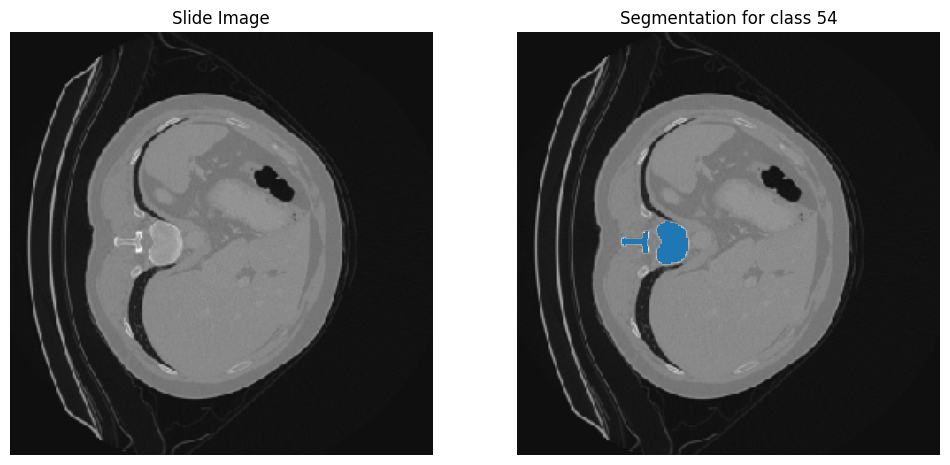

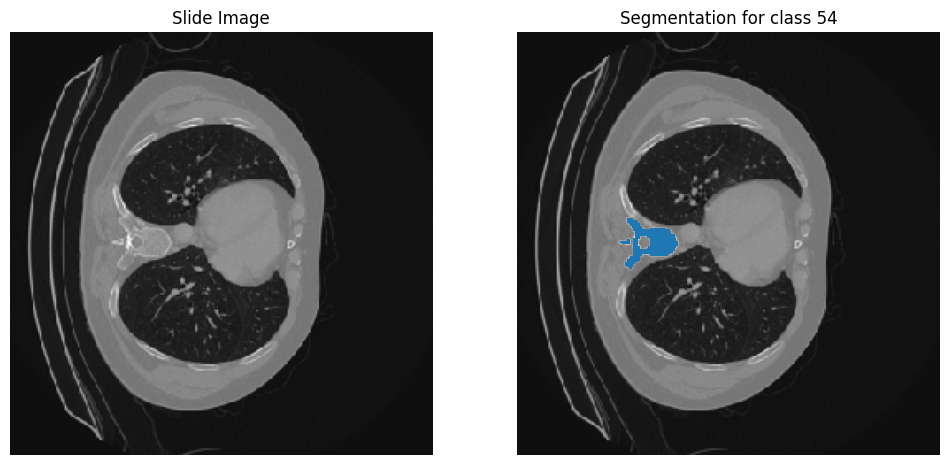

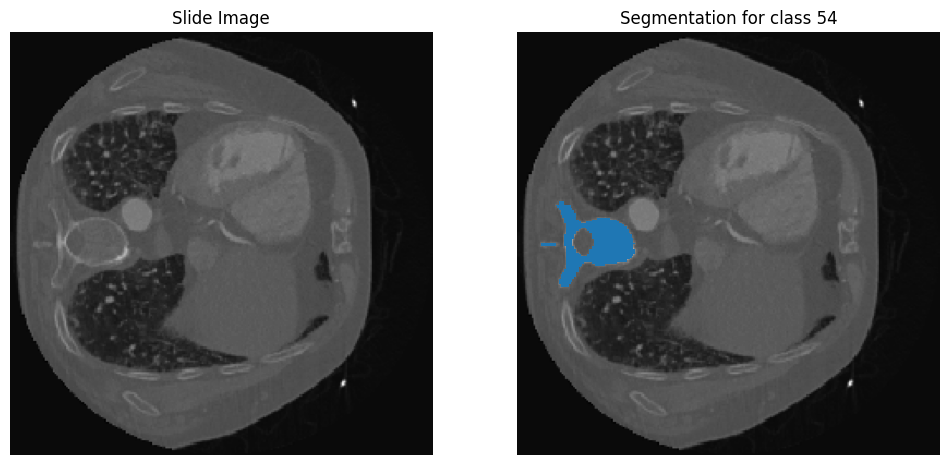

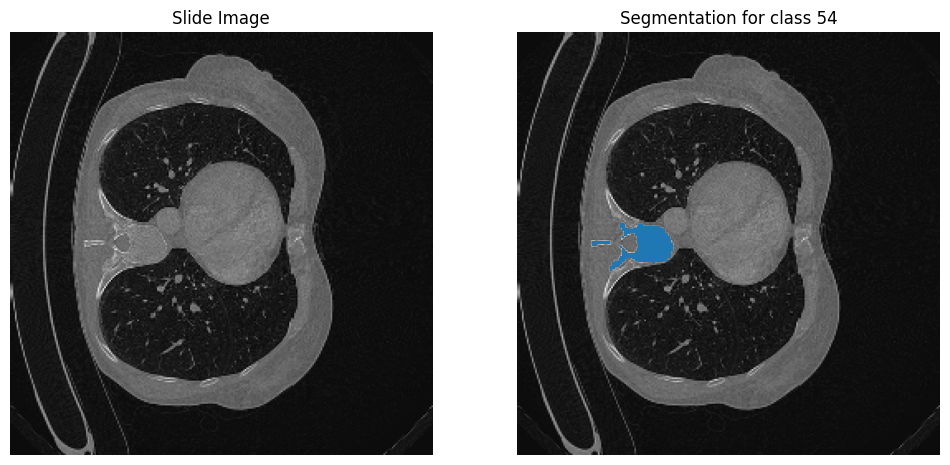

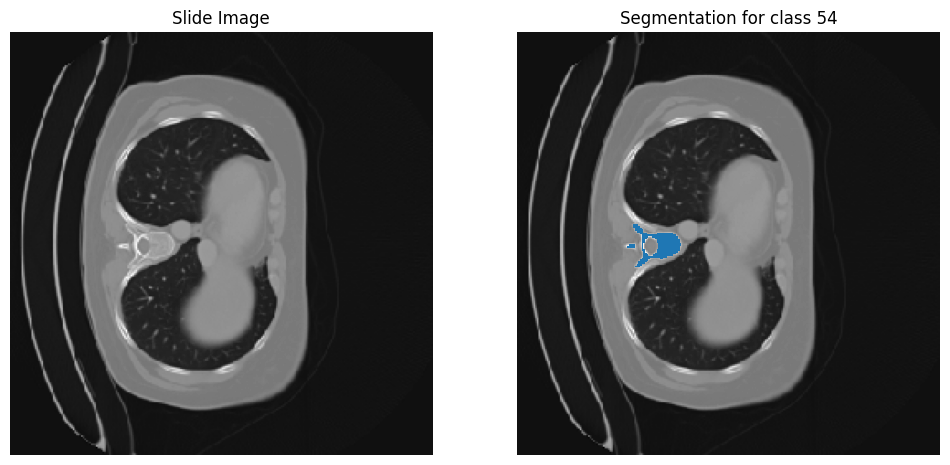

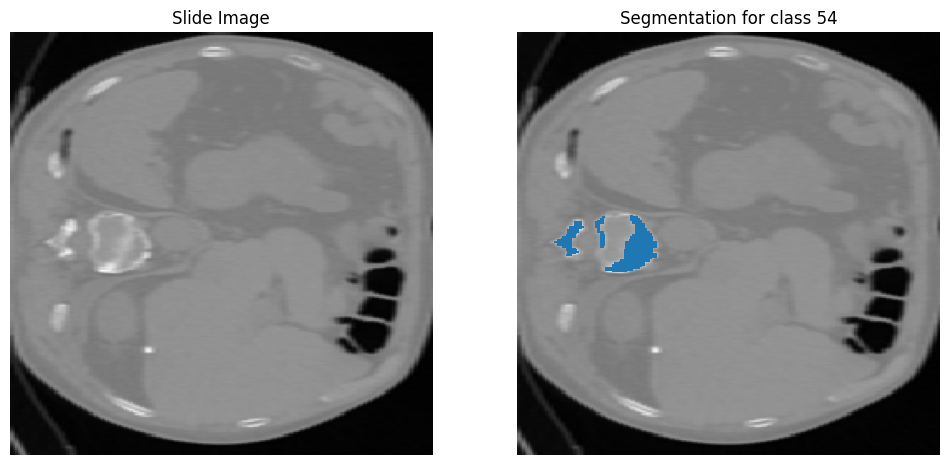

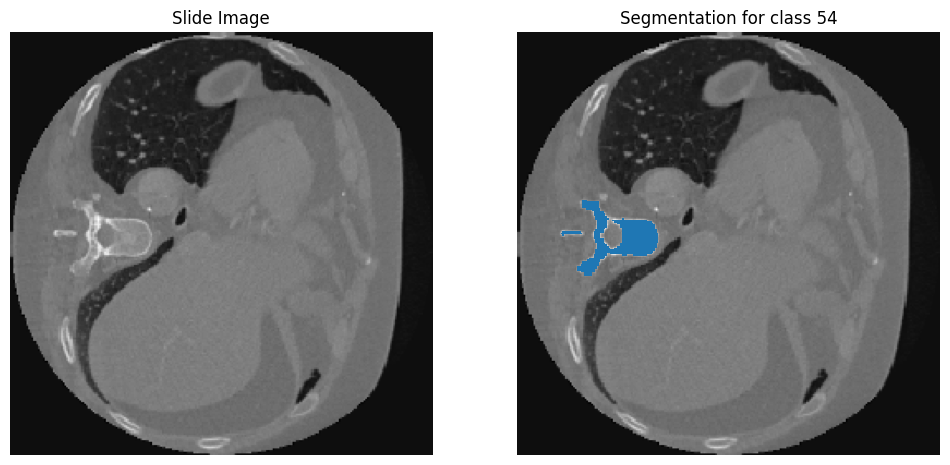

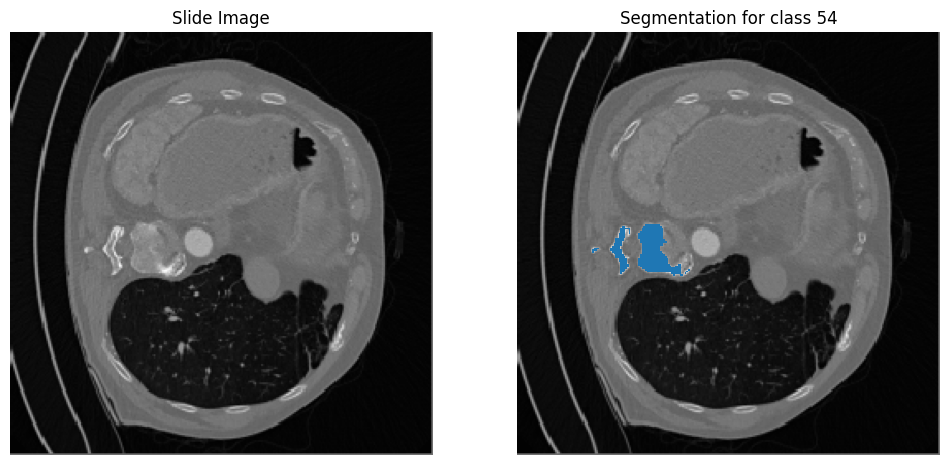

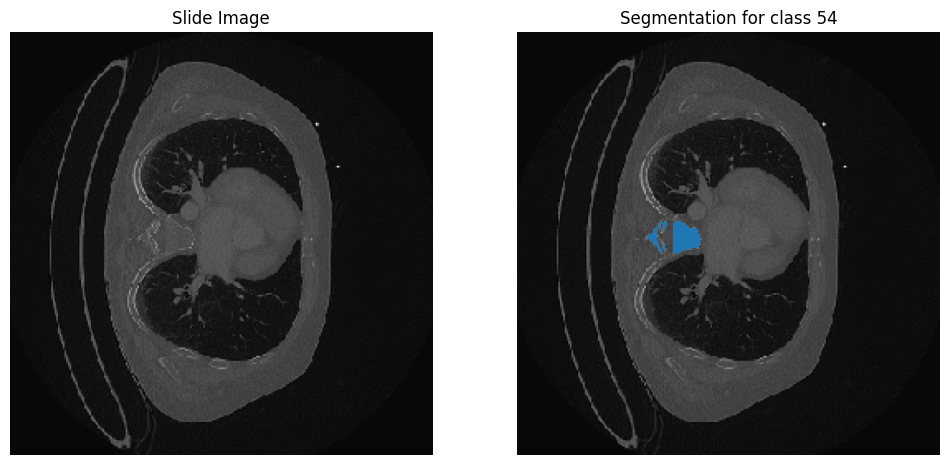

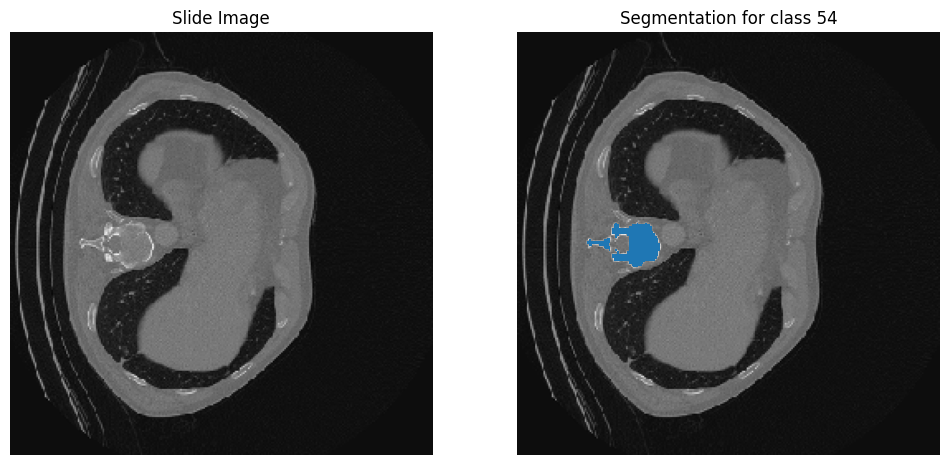

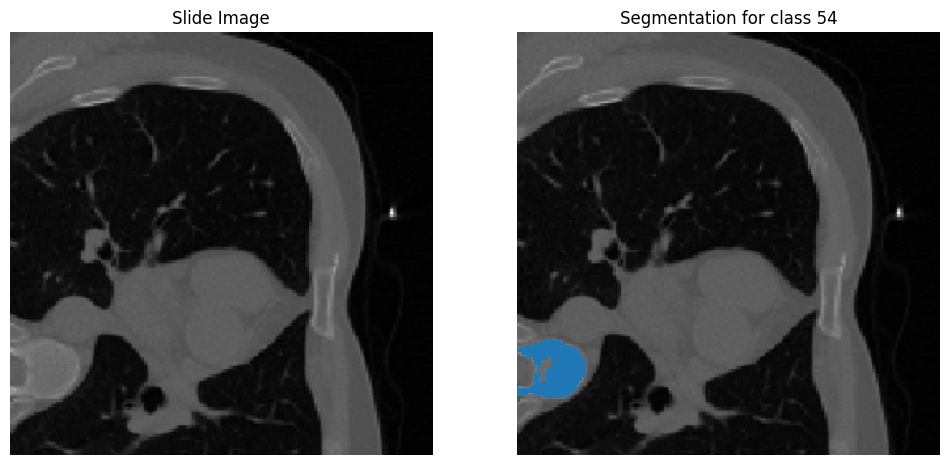

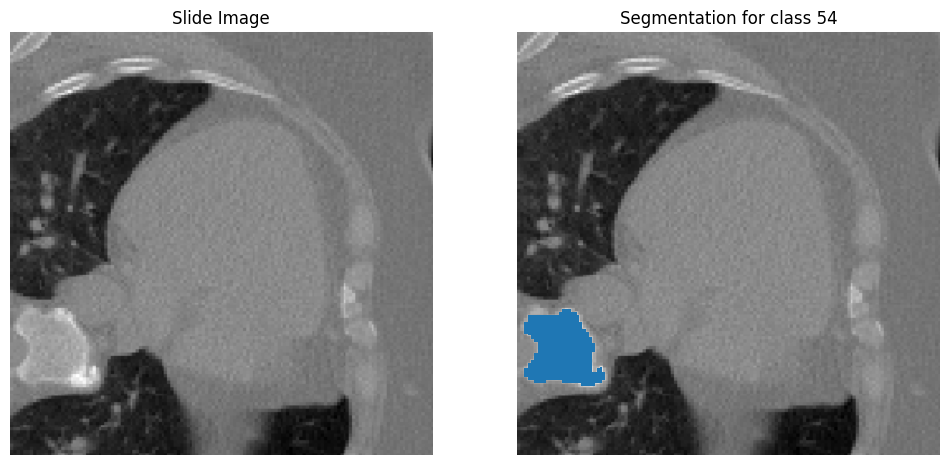

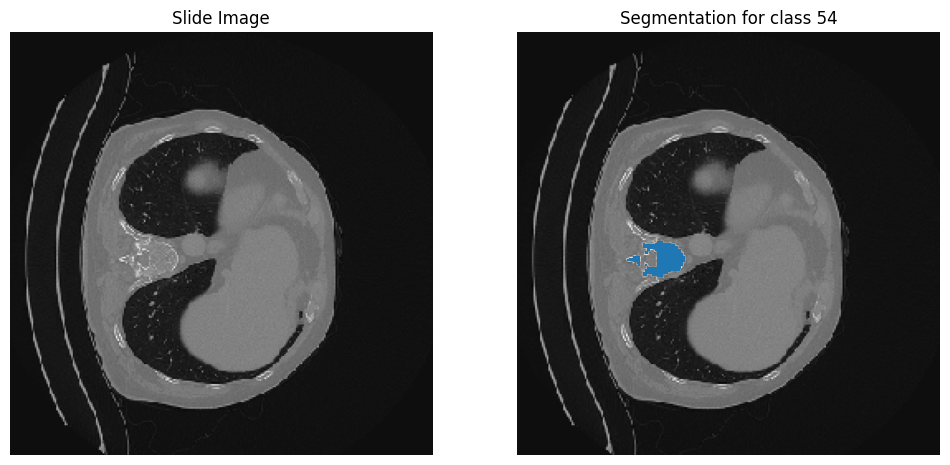

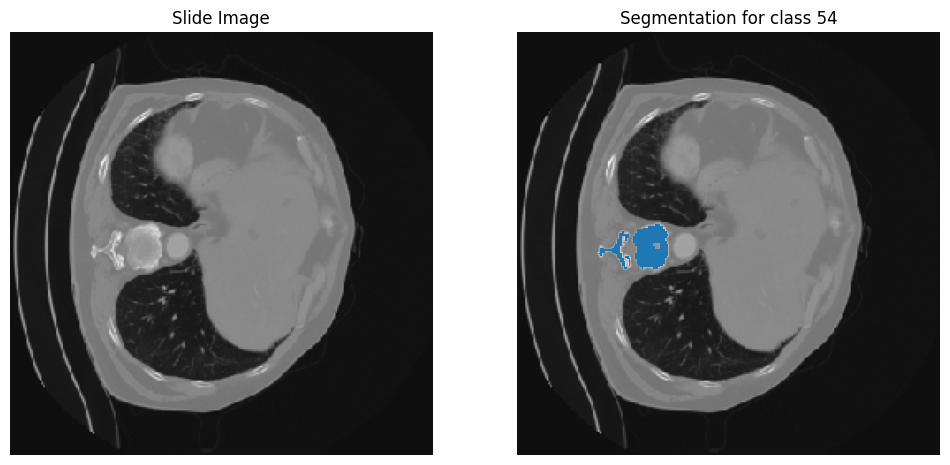

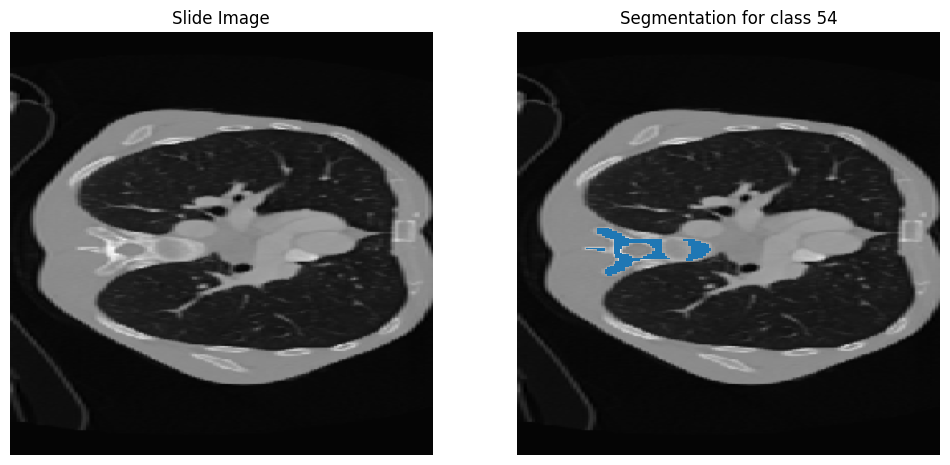

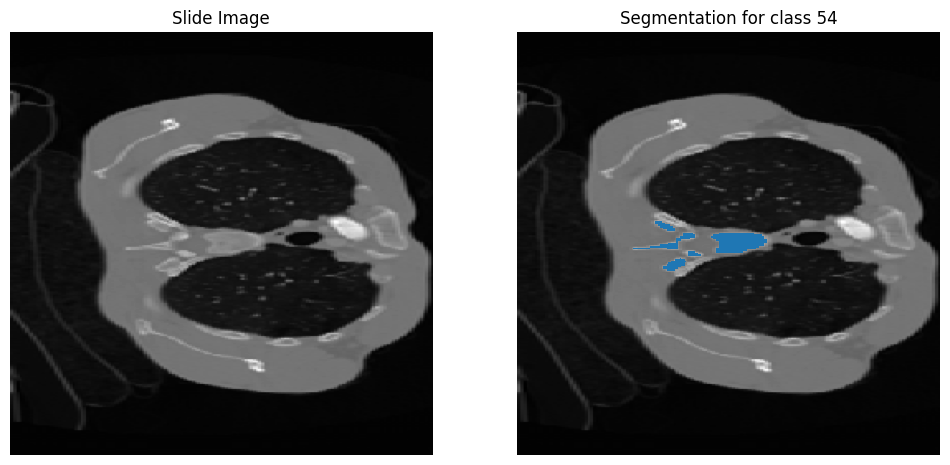

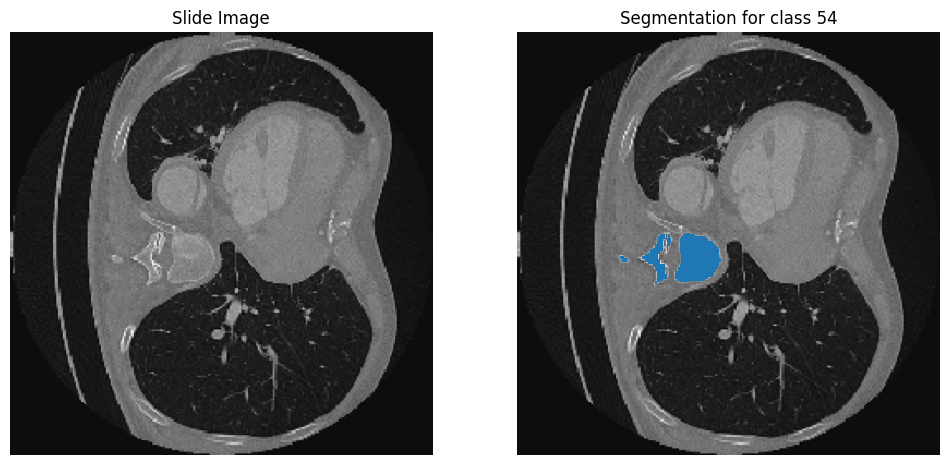

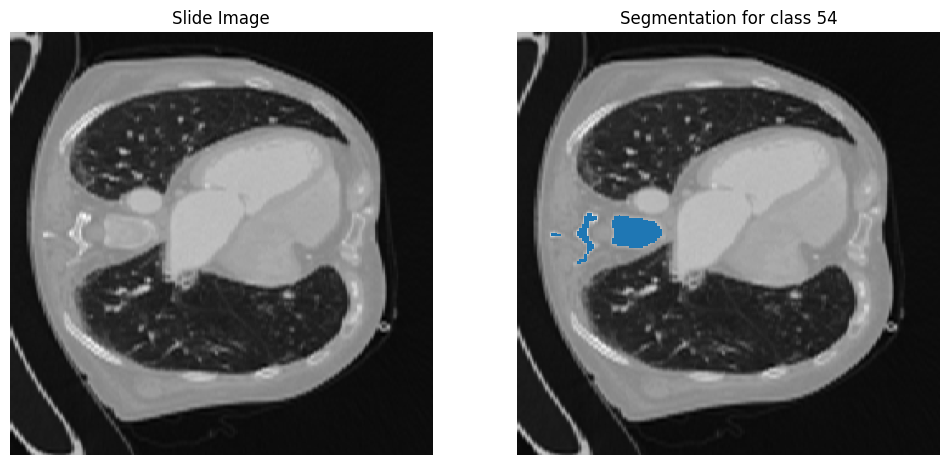

KeyboardInterrupt: 

In [37]:
for i in range(500):
  plot_slice_class(data_train[i], labels_train.iloc[i].values.reshape((256,256)), 54)

## Dataset analysis

In [ ]:
# Boolean mask for rows that contain only zeros
zero_rows = labels_train.eq(0).all(axis=1)

# Count rows that contain only zeros (unannotated images)
unannotated_labels_train = zero_rows.sum()

print(f"Number of unannotated images in labels_train: {unannotated_labels_train}")

In [ ]:
# Boolean mask for rows that contain at least one nonzero pixel
annotated_rows = labels_train.ne(0).any(axis=1)

# Filter only the 800 images with labeled structures
labels_train_annotated = labels_train[annotated_rows]

# Print the number of remaining images
print(f"Number of annotated images in labels_train: {labels_train_annotated.shape[0]}")

In [ ]:
# Count the number of images with empty lists (unannotated)
unannotated_json = sum(len(labels) == 0 for labels in annotated_labels)

print(f"Number of unannotated images in annotated_labels.json: {unannotated_json}")

In [ ]:
# Count the number of images with empty lists (unannotated)
annotated_json = sum(len(labels) > 0 for labels in annotated_labels)

print(f"Number of annotated images in annotated_labels.json: {annotated_json}")

In [ ]:
# Labels are 0 for background and 1 to 54 for all organs
print(sorted(labels_train.stack().unique()))

In [ ]:
# Example

image_id = 39
labels_for_image = annotated_labels[image_id]

print(f"{len(labels_for_image)} annotated labels for image {image_id}.png: {labels_for_image}")

In [ ]:
# less labels actually present in labels_train... others replaced by 0s...
labels_train.loc["39.png"].value_counts()

In [ ]:
print(f"Number of annotated images in labels_train: {labels_train_annotated.shape[0]}")

# Get the indices (or filenames) of annotated images.
# (Assuming that the index of labels_df is the image filename, e.g. "0.png", "1.png", etc.)
annotated_filenames = labels_train_annotated.index.tolist()
print("Annotated filenames (first 10):", annotated_filenames[:10])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming labels_train is already loaded, for example:
# labels_train = pd.read_csv("y_train.csv", index_col=0).T

# Flatten all values and compute frequency counts
all_values = labels_train.values.flatten()
frequency = pd.Series(all_values).value_counts().sort_index()

# Exclude class 0
if 0 in frequency.index:
    frequency = frequency.drop(0)

print(frequency)

# Create a bar chart
plt.figure(figsize=(10, 6))
frequency.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Frequency of Each Class in y_train.csv (excluding class 0)")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Read the entire CSV and select only 10 random rows
train_df = pd.read_csv("y_train.csv", index_col=0).sample(n=30, axis=1, random_state=42)

# Save the selected subset to a new CSV file
train_df.to_csv("y_train_sampled.csv", index=True)

print("Saved y_train_sampled.csv with shape:", train_df.shape)

In [41]:
!git clone https://github.com/facebookresearch/segment-anything-2

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 43.43 MiB/s, done.
Resolving deltas: 100% (376/376), done.


In [ ]:
!cd segment-anything-2 && ls && pip install -e .

assets		    demo		 MANIFEST.in	   sam2
backend.Dockerfile  docker-compose.yaml  notebooks	   sav_dataset
checkpoints	    INSTALL.md		 pyproject.toml    setup.py
CODE_OF_CONDUCT.md  LICENSE		 README.md	   tools
CONTRIBUTING.md     LICENSE_cctorch	 RELEASE_NOTES.md  training
Obtaining file:///kaggle/working/segment-anything-2


In [38]:
import os
os.chdir("/kaggle/working/")
!wget -O sam2_hiera_base_plus.pt "https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt"

--2025-03-07 19:35:23--  https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.14, 3.163.189.108, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323493298 (309M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2_hiera_base_plus.pt’

sam2_hiera_base_plu 100%[===================>] 308.51M   293MB/s    in 1.1s    

2025-03-07 19:35:24 (293 MB/s) - ‘sam2_hiera_base_plus.pt’ saved [323493298/323493298]



In [39]:
!mkdir data && mv train-images test-images y_train.csv data

In [40]:
!ls

annotated_labels.json	 sam2_hiera_base_plus.pt  train-images.zip
annotated_labels.json.1  test-images.zip	  train-images.zip.1
data			 test-images.zip.1


In [ ]:
import os
os.chdir("/kaggle/working/")

import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ----------------------------
# Step 1. Configuration and Paths
# ----------------------------
# Define the base data folder (adjust as needed)
DATA_FOLDER = "data"  # No trailing slash

# Define paths for original train images and the CSV file containing masks
TRAIN_IMAGES_DIR = os.path.join(DATA_FOLDER, "train-images")
Y_TRAIN_CSV = os.path.join(DATA_FOLDER, "y_train.csv")

# Define the output folder for the masks and for the new train CSV
MASKS_DIR = os.path.join(DATA_FOLDER, "masks")
os.makedirs(MASKS_DIR, exist_ok=True)

# ----------------------------
# Step 2. Load and Filter y_train.csv
# ----------------------------
# Load the CSV; note that the CSV is transposed so that each row corresponds to an image
df = pd.read_csv(Y_TRAIN_CSV, index_col=0).T
print("Original y_train.csv shape:", df.shape)

# Filter out rows that contain only zeros (no annotated mask)
mask = ~(df.values == 0).all(axis=-1)
df_filtered = df[mask]
print("Filtered train data shape:", df_filtered.shape)

In [ ]:
df_filtered.index

In [ ]:
# ----------------------------
# Step 3. Reshape and Save Masks as Images
# ----------------------------
# For each row in the filtered DataFrame, reshape the flattened mask into 256x256 and save as an image
for file_name in df_filtered.index:
    # Get the flattened mask as a numpy array (assumed type convertible to uint8)
    mask_flat = df_filtered.loc[file_name].values.astype(np.uint8)
    # Reshape into 256x256 (since 256*256 = 65536)
    mask_img = mask_flat.reshape(256, 256)

    # Replace all non-zero values with 1
    #mask_img[mask_img != 0] = 1

    # Save the mask image into the MASKS_DIR with the same filename (e.g., "23.png")
    out_path = os.path.join(MASKS_DIR, file_name)
    cv2.imwrite(out_path, mask_img)

print("Saved masks to:", MASKS_DIR)

# Step 4. Create a New CSV File Mapping Filtered Images to Masks

# Use the filtered train_df index (which contains only images for which a mask was saved)
filtered_filenames = list(df_filtered.index)  # e.g. ['23.png', '45.png', ..., 'xxx.png']
print(filtered_filenames[:10])

# (Optionally, sort them numerically using a helper function)
import re
def numeric_key(filename):
    number_str = re.sub(r'\D', '', filename)
    return int(number_str) if number_str else float('inf')

filtered_filenames = sorted(filtered_filenames, key=numeric_key)

# Create a DataFrame with two columns: ImageId and MaskId.
# We assume that the mask files in the masks folder have the same filenames as in the filtered list.
train_csv_df = pd.DataFrame({
    "ImageId": filtered_filenames,
    "MaskId": filtered_filenames  # because masks are saved with the same names in data/masks
})

# Save this DataFrame as "train.csv" in your DATA_FOLDER.
TRAIN_CSV_PATH = os.path.join(DATA_FOLDER, "train.csv")
train_csv_df.to_csv(TRAIN_CSV_PATH, index=False)
print("Created new CSV mapping images to masks at:", TRAIN_CSV_PATH)

# ----------------------------
# Step 5. (Optional) Split the Data into Train and Test Sets
# ----------------------------
# If you wish to split your dataset into train and test sets for fine-tuning SAM2,
# you can use train_test_split. For example:
train_split, test_split = train_test_split(train_csv_df, test_size=0.2, random_state=42)
train_split.to_csv(os.path.join(DATA_FOLDER, "train_split.csv"), index=False)
test_split.to_csv(os.path.join(DATA_FOLDER, "test_split.csv"), index=False)
print("Saved train_split.csv and test_split.csv in", DATA_FOLDER)

# ----------------------------
# Summary:
# Your data is now restructured as follows:
#   - Train images are in:    DATA_FOLDER/train-images/
#   - Masks are now saved in:  DATA_FOLDER/masks/
#   - A new CSV file mapping images to masks is saved as: DATA_FOLDER/train.csv
#   - (Optionally) train/test split CSV files are also created.
#
# You can now use these files with the SAM2 fine-tuning tutorial.

In [ ]:
import matplotlib.colors as mcolors

def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    image_path = ent["image"]
    annotation_path = ent["annotation"]

    Img = cv2.imread(image_path)

    if Img is None:
        print(f"Error: Could not read image from {image_path}")
        return None, None, None, 0

    # Convert BGR to RGB
    Img = Img[..., ::-1]
    
    # Get full paths
    ann_map = cv2.imread(annotation_path, cv2.IMREAD_GRAYSCALE)
    
    if Img is None or ann_map is None:
       print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
       return None, None, None, 0
    
    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
    
    ### Continuation of read_batch() ###
    
    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []
    
    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
       mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
       binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask
    
    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
       for _ in inds:  # Select as many points as there are unique labels
           yx = np.array(coords[np.random.randint(len(coords))])
           points.append([yx[1], yx[0]])

    points = np.array(points)
    
    ### Continuation of read_batch() ###
    
    if visualize_data:
        # Plotting the images and points
        plt.figure(figsize=(15, 5))
    
        # Original Image
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(Img)
        plt.axis('off')

        # Segmentation Mask (binary_mask)
        plt.subplot(1, 3, 2)
        plt.title('Binarized Mask')
        plt.imshow(binary_mask, cmap='gray')
        plt.axis('off')
    
        # Mask with Points in Different Colors
        plt.subplot(1, 3, 3)
        plt.title('Binarized Mask with Points')
        plt.imshow(binary_mask, cmap='gray')
    
        # Plot points in different colors
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i, point in enumerate(points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], s=100, label=f'Point {i+1}')  # Corrected to plot y, x order
    
        # plt.legend()
        plt.axis('off')
    
        plt.tight_layout()
        plt.savefig("fig.png")
        plt.show()

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)
    
    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

In [ ]:
images_dir = "data/train-images"
masks_dir = "data/masks"

# Prepare the training data list
train_data = []
for index, row in train_split.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   train_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })

# Prepare the testing data list (if needed for inference or evaluation later)
test_data = []
for index, row in test_split.iterrows():
   image_name = row['ImageId']
   mask_name = row['MaskId']

   # Append image and corresponding mask paths
   test_data.append({
       "image": os.path.join(images_dir, image_name),
       "annotation": os.path.join(masks_dir, mask_name)
   })

In [ ]:
# Visualize the data
os.chdir("/kaggle/working")
Img1, masks1, points1, num_masks = read_batch(train_data, visualize_data=True)

In [ ]:
os.chdir("/kaggle/working/segment-anything-2")
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "/kaggle/working/sam2_hiera_base_plus.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2_hiera_b+.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

In [ ]:
import torch 

# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 3000 # @param 

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"

In [ ]:
os.chdir("/kaggle/working/")

print("Preparing training")

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 2  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
    with torch.cuda.amp.autocast():
        image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)

    if image is None or mask is None or num_masks == 0:
       continue
    
    input_label = np.ones((num_masks, 1))
    if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
       continue
    
    if input_point.size == 0 or input_label.size == 0:
       continue
    
    predictor.set_image(image)
    mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
    if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
       continue
    
    sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
       points=(unnorm_coords, labels), boxes=None, masks=None,
    )
    
    batched_mode = unnorm_coords.shape[0] > 1
    high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
    low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
       image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
       image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
       sparse_prompt_embeddings=sparse_embeddings,
       dense_prompt_embeddings=dense_embeddings,
       multimask_output=True,
       repeat_image=batched_mode,
       high_res_features=high_res_features,
    )
    prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
    
    
    gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
    prd_mask = torch.sigmoid(prd_masks[:, 0])
    seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()
    
    inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
    iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
    score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
    loss = seg_loss + score_loss * 0.05
    
    # Apply gradient accumulation
    loss = loss / accumulation_steps
    scaler.scale(loss).backward()
    
    # Clip gradients
    torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)
    
    if step % accumulation_steps == 0:
       scaler.step(optimizer)
       scaler.update()
       predictor.model.zero_grad()
    
    # Update scheduler
    scheduler.step()
    
    if step % 500 == 0:
       FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
       torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)
    
    if step == 1:
       mean_iou = 0

    if step % 50 == 0:
        print(step)
    
    mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
    
    if step % 100 == 0:
       print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)

In [ ]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

In [ ]:
import torch
import random
torch.cuda.empty_cache()

# Randomly select a test image from the test_data
selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

# Load the selected image and mask
image, mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 20  # Number of points per segment to sample
input_points = get_points(mask, num_samples)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_2000.torch"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])

if scores.ndim == 1:
    np_scores = scores
else:
    np_scores = scores[:, 0]

sorted_masks = np_masks[np.argsort(np_scores)][::-1]

print(sorted_masks.shape)

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   mask = sorted_masks[i]
   if (mask * occupancy_mask).sum() / mask.sum() > 0.15:
       continue

   mask_bool = mask.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

if mask.ndim == 1:
    mask = mask.reshape(32, 32)

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

if seg_map.ndim == 1:
    seg_map =seg_map.reshape(32, 32)

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
np.unique(seg_map)